In [8]:
using Pkg
Pkg.activate("/Users/yusuke/program/julia_module/MyPackage")
using MyPackage

using Healpix
using Plots
using NPZ
using LinearAlgebra
using LsqFit
using StatsBase
using BenchmarkTools
using PyCall
using TickTock
using Base.Threads
using StatsPlots
using PyPlot
using DSP
using FFTW
gr()

hp =  pyimport("healpy")
np = pyimport("numpy")
sns = pyimport("seaborn")
plt = pyimport("matplotlib.pyplot")
sp = pyimport("scipy.optimize")
nth = nthreads()# for parallerize

@inline function MultiTrack_calculation(
    NSIDE::Integer,
    start::Integer,
    stop::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    loop = ((stop - start) * smp_rate) + 1

    #println("time=",loop)
    res = Resolution(NSIDE)

    α = 45(π / 180)
    β = 50(π / 180)
    orbit3D = zeros(Float64, loop, 3)
    orbit2D = zeros(Float64, loop, 2)
    dif3D = zeros(Float64, loop-1, 3)
    dif2D = zeros(Float64, loop-1, 2)
    theta_axis3D = zeros(Float64, loop, 3)

    theta_axis = zeros(Float64, loop, 2)
    sky_axis = zeros(Float64, loop, 3)

    pix = zeros(Int64, loop, length(dθ))
    psi_i = zeros(Float64, loop, length(dθ))
    cb = cos(β)
    sb = sin(β)
    ca = cos(α)
    sa = sin(α)
    println("Start track calculation!")

    for j in eachindex(dθ)
        println("j=", j)
        #origin =[cos(dθ[j]) * cos(dφ[j]); cos(dθ[j]) * sin(dφ[j]); sin(dθ[j])]
        origin = [
        cosd(dθ[j]) -sind(dθ[j]) 0
        sind(dθ[j])*cosd(dφ[j]) cosd(dθ[j])*cosd(dφ[j])  -sind(dφ[j])
        sind(dθ[j])*sind(dφ[j]) cosd(dθ[j])*sind(dφ[j])  cosd(dφ[j])
        ]*[1;0;0]

        @inbounds @threads for i in 1:loop
            t = start + (i-1)/smp_rate

            ωₐt = ((2π / 60) / 192.348)t
            ωᵦt = (0.05π / 30)t
            ωᵣt = (2π)t / (60 * 60 * 24 * 365)
            cwb = cos(ωᵦt)
            swb = sin(ωᵦt)
            cwa = cos(ωₐt)
            swa = sin(ωₐt)
            cwr = cos(ωᵣt)
            swr = sin(ωᵣt)

            rot_spin = [
                cb -sb 0
                sb*cwb cb*cwb -swb
                sb*swb cb*swb cwb
            ]
            vec_1 = @views rot_spin * origin

            rot_prec = [
                ca -sa 0
                sa*cwa ca*cwa -swa
                sa*swa ca*swa cwa
            ]
            vec_2 = @views rot_prec * vec_1

            rot_sun = [
                cwr -swr 0
                swr cwr 0
                0 0 1
            ]
            vec_3 = @views rot_sun * vec_2

            orbit3D[i, 1] = vec_3[1]
            orbit3D[i, 2] = vec_3[2]
            orbit3D[i, 3] = vec_3[3]

            ang = @views vec2ang(
                orbit3D[i, 1],
                orbit3D[i, 2],
                orbit3D[i, 3],
            )

            orbit2D[i, 1] = ang[1]
            orbit2D[i, 2] = ang[2]

            theta_axis[i, 1] = orbit2D[i, 1] + (π / 180) * 1e-7

            vec = @views ang2vec(theta_axis[i, 1], orbit2D[i, 2])
            sky_axis[i, 1] = vec[1] - orbit3D[i, 1]
            sky_axis[i, 2] = vec[2] - orbit3D[i, 2]
            sky_axis[i, 3] = vec[3] - orbit3D[i, 3]
            pix[i, j] = ang2pix(m, orbit2D[i, 1], orbit2D[i, 2])
        end

        @inbounds @threads for i in 1:loop-1
            dif3D[i, 1] = orbit3D[i+1, 1] - orbit3D[i, 1]
            dif3D[i, 2] = orbit3D[i+1, 2] - orbit3D[i, 2]
            dif3D[i, 3] = orbit3D[i+1, 3] - orbit3D[i, 3]
            dif2D[i, 1] = orbit2D[i+1, 1] - orbit2D[i, 1]
            dif2D[i, 2] = orbit2D[i+1, 2] - orbit2D[i, 2]

            Vvec = @views dif3D[i, :]
            nvec = @views sky_axis[i, :]
            inner = dot(Vvec, nvec)
            L_dif =
                √(dif3D[i, 1]^2 + dif3D[i, 2]^2 + dif3D[i, 3]^2)
            L_axis = √(
                sky_axis[i, 1]^2 +
                sky_axis[i, 2]^2 +
                sky_axis[i, 3]^2,
            )

            cos_psi = inner / (L_dif * L_axis)

            if dif2D[i, 2] > π
                dif2D[i, 2] = dif2D[i, 2] - 2π
            end
            if dif2D[i, 2] < -π
                dif2D[i, 2] = dif2D[i, 2] + 2π
            end

            judge = sign(-dif2D[i, 2])
            psi_i[i, j] = acos(cos_psi) * judge
        end
    end
    return pix, psi_i
end


function get_psi_and_pix(
    NSIDE::Integer,
    times::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    split_num = 6
    month = Int64(times/split_num)


    hit_pix = zeros(Int64, NPIX)
    theta_line_pix = Int64[]
    theta_line_psi = Float64[]

    Begin = 0
    
    deg = 90(π/180)
    dphi = 20(π/180)

    for i = 1:split_num
        println("process=", i, "/", split_num)
        stop = i*month

        #println("calc_", start, "_to_", stop)
        #println("Finish is =", times)
        PIX, PSI_i = MultiTrack_calculation(NSIDE, Begin, stop, smp_rate, dθ, dφ)

        loop_times = length(PSI_i)
        #println("Start reconstruct!")
        #println("loop_times=", loop_times)
        bore_pix = @views PIX
        #ghost_pix = @views PIX[:, 2]
        psi_i = @views PSI_i
        
        pix_pi2 = hp.pix2ang(NSIDE, bore_pix)[2]
    
        for k in 1:loop_times
            bore = bore_pix[k]
            #ghost = ghost_pix[k]
            psi = psi_i[k]
            TIME = Begin + (k-1)/smp_rate
            
            
            if pix_pi2[k] < deg + dphi
                if pix_pi2[k] > deg - dphi
                    push!(theta_line_pix, bore)
                    push!(theta_line_psi, psi)
                end
            end

            hit_pix[bore] += 1
        end
        Begin = stop + 1
    end
    
    return hit_pix, theta_line_pix, theta_line_psi
end

function dist_FWHM(copol, theta_line_pix, phi90pix)
    @. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))
    ddeg = np.deg2rad(0.36)
    FWHM = zeros(length(phi90pix)-2)
    
    for i in 2:99
        
        index = np.where(theta_line_pix .== phi90pix[i])[1] .+1

        psi_in_ipix = zeros(length(index))
        @threads for i in eachindex(index)
            psi_in_ipix[i] = theta_line_psi[index[i]] 
        end

        copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)
        
        xdata = @views [reverse(theta[:,1]) ; -theta[:,500]]  
        ydata = @views [reverse(copol_sym[:,1])  ;copol_sym[:,500]]

        p0 = [136, 0.003]

        Fit = curve_fit(gaussian2, xdata, ydata, p0)
        #gauss = gaussian2(xdata, Fit.param)
        FWHM[i-1] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
        #println(i)
        #println(FWHM[i])
    end
    return FWHM
end


get_psi_and_pix (generic function with 1 method)

In [9]:
const NSIDE = 128
const NPIX = nside2npix(NSIDE)
const m = Map{Float64,RingOrder}(NSIDE)
const day = 60 * 60 * 24
const year = day * 365
smp_rate = 5
times = year

println("SR=", smp_rate)

dth = [5.86]
dph = [189.20]


SR=1


1-element Array{Float64,1}:
 189.2

In [10]:
tick()
hit_pix, theta_line_pix, theta_line_psi = get_psi_and_pix(NSIDE, times, smp_rate, dth, dph)
tock()

┌ Info:  started timer at: 2020-08-26T19:29:44.261
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:32


process=1/6
Start track calculation!
j=1
Start reconstruct!
process=2/6
Start track calculation!
j=1
Start reconstruct!
process=3/6
Start track calculation!
j=1
Start reconstruct!
process=4/6
Start track calculation!
j=1
Start reconstruct!
process=5/6
Start track calculation!
j=1
Start reconstruct!
process=6/6
Start track calculation!
j=1
Start reconstruct!


┌ Info:         72.563832093s: 1 minute, 12 seconds, 563 milliseconds
└ @ TickTock /Users/yusuke/.julia/packages/TickTock/3F6de/src/TickTock.jl:39


In [11]:
#Theta_line, phi90pix = MyPackage.lineget(NSIDE, theta_line_pix, theta_line_psi, 256)
div = 100
elev = np.linspace(0, π, div)
azim = ones(div) .* π / 2
phi90pix = hp.ang2pix(NSIDE, elev, azim)
#np.save("/Users/yusuke/program/LiteBIRD_sim/beam_study", phi90pix)

100-element Array{Int64,1}:
      1
     45
    190
    435
    780
   1225
   1770
   2415
   3160
   4005
   4950
   5995
   7140
      ⋮
 190503
 191558
 192513
 193368
 194123
 194778
 195333
 195788
 196143
 196398
 196553
 196605

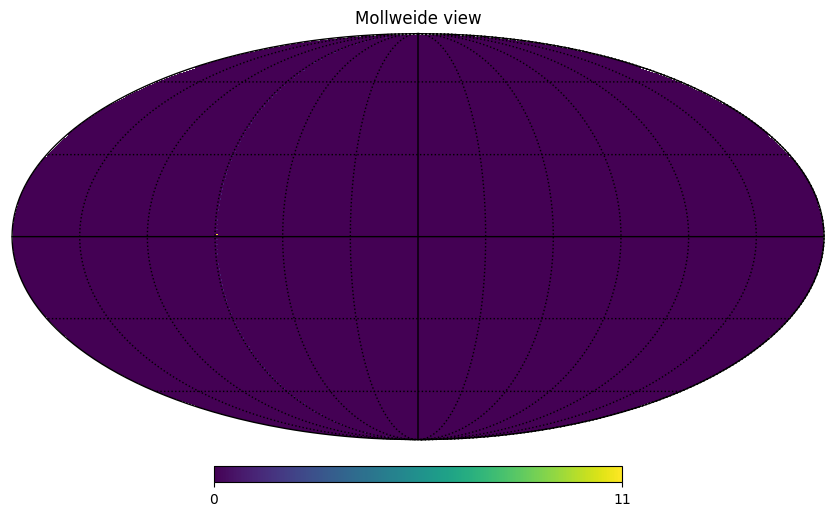

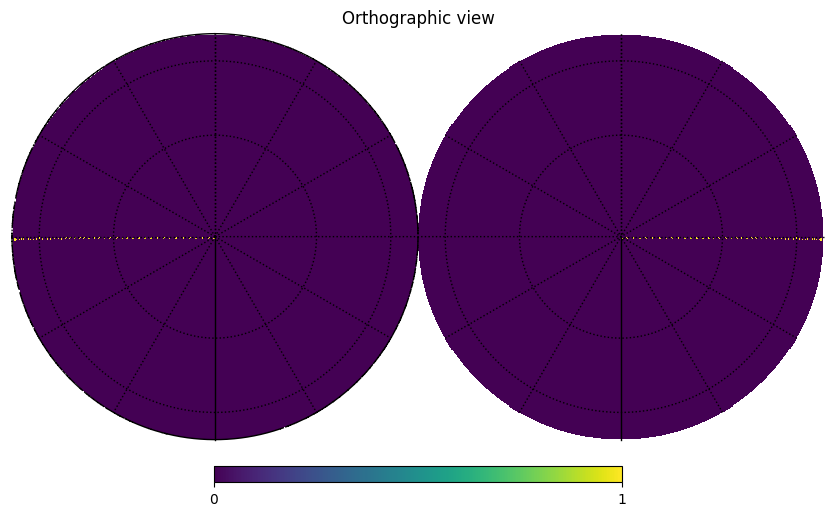

In [12]:
I_lu = zeros(NPIX)
for i in 1:length(phi90pix)
    if phi90pix[i] == 96640
        I_lu[phi90pix[i]] += 10
    end
    I_lu[phi90pix[i]] += 1
end

#Plots.plot(MyPackage.gen_map(NSIDE, I_lu), c=:jet)
#=
hp.mollview(I_lu)
hp.graticule()
hp.orthview(I_lu, rot=(0,90))
hp.graticule()
=#

In [16]:
data = npzread("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/20200731_red_pix_40GHz/m125_m20_40.0G_000deg_tp.npz")
N = 1001

phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
X = theta .* cos.( phi )
Y = theta .* sin.( phi )
length(theta)

1002001

pix=196553

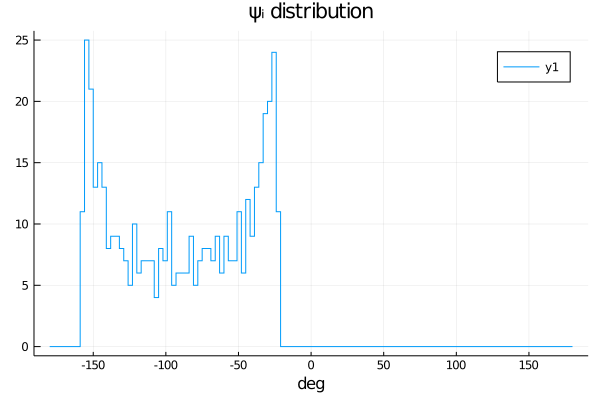

In [36]:
#print(Int.(Theta_line[1,:])[220])
#index = np.where(Int.(Theta_line[1,:]) .==52608)[1] .+1
pixnmb = 99
index = np.where(theta_line_pix .== phi90pix[pixnmb])[1] .+1

psi_in_ipix = zeros(length(index))
for i in 1:length(index)
    psi_in_ipix[i] = theta_line_psi[index[i]] 
end
ddeg = np.deg2rad(0.36)
print("pix=",phi90pix[pixnmb])

copol = np.reshape(data["copol"], [N, N])
copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

edge = -180:3:180

psi_dist = fit(Histogram, np.rad2deg(psi_in_ipix), edge)

Plots.plot(psi_dist,
    title = "ψᵢ distribution",
    xlabel="deg",
    seriestype = :step, fmt=:png)

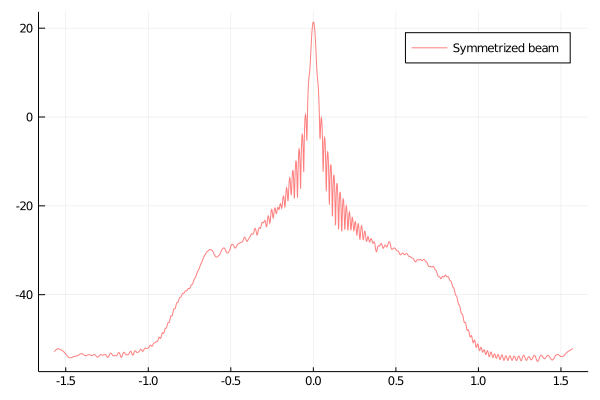

In [62]:
#Plots.plot( theta[:,1], 10log10.(copol[:,1]), color=:green, alpha=0.5, label="Origin beam", fmt=:png)
#Plots.plot!( -theta[:,500], 10log10.(copol[:,500]), color=:green, alpha=0.5, label=:none)

Plots.plot( theta[:,1], 10log10.(copol_sym[:,1]), color=:red, alpha=0.5, label="Symmetrized beam")
Plots.plot!( -theta[:,501], 10log10.(copol_sym[:,501]), color=:red, alpha=0.5, label=:none)

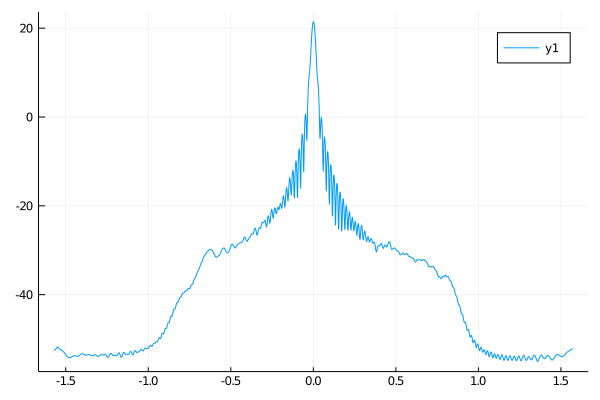

In [63]:
cut=1001
a = [reverse(copol_sym[1:cut,1])  ;copol_sym[1:cut,501]]
b = [reverse(theta[1:cut,1]) ; -theta[1:cut,501]]
Plots.plot(b, 10log10.(a))


[138.75326468283987, 0.008784952025636259]
FWHM=71.11660255839469


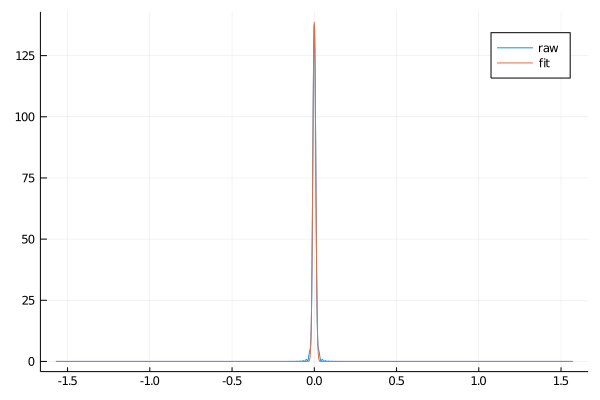

In [24]:


p0 = [136, 0.003]
xdata = b
ydata = a

Fit = curve_fit(gaussian2, xdata, ydata, p0)
println(Fit.param)

gauss = gaussian2(xdata, Fit.param)
FWHM = 2*√(2*log(2))*Fit.param[2]
println("FWHM=", np.rad2deg(FWHM)*60)

Plots.plot(xdata, ydata, label = "raw")
Plots.plot!(xdata, gauss, label = "fit")

dist_FWHM (generic function with 1 method)

In [48]:
fwhm = dist_FWHM(copol, theta_line_pix, phi90pix)

98-element Array{Float64,1}:
 73.71458778636448
 73.30403519009519
 72.79887316283623
 73.28140214595301
 73.69382513980496
 72.68122478170827
 73.00034573214005
 73.30046381482887
 72.46358019372668
 72.51647881749241
 72.13840851525846
 73.26207185183586
 73.33601830084353
  ⋮
 73.52071472803918
 72.64657621088155
 72.52318401787628
 72.8867525325872
 73.0576378162349
 72.91517397675734
 73.17770412575715
 72.98261817251765
 73.35527282552044
 73.53014386759855
 73.57987742522842
 73.38973690057954

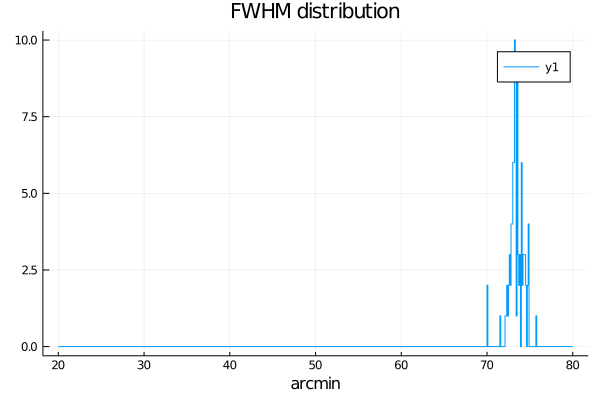

In [52]:
edge = 20:0.1:80
fwhm_dist = fit(Histogram, fwhm, edge)

Plots.plot(fwhm_dist,
    title = "FWHM distribution",
    xlabel="arcmin",
    seriestype = :step, fmt=:png)